# Imports

In [1]:
import numpy as np
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import Estimator

# Experimental Setup

Note: Throughout this notebook we consider vertically polarized light as $\ket{0}$ and horizontally polarized light as $\ket{1}$. We also refer detection site A as "Alice" and site B as "Bob" following standard quantum information theory language.

First, we illumitate a 440-nm lazer and on a pair of Barium Borate(BBO) crystals to produced pairs of entangled photons with a wavelength $\approx$ 880-nm. The light polarization of the light should be at $45^{\circ}$ with respect to one of the BBO crystal's axis. To learn more please read the referred paper. Then, we need to do the following:
1. Check the purity of the entanled pair by doing 4 measurements. $N(0^{\circ}, 0^{\circ}), N(90^{\circ}, 90^{\circ}), N(45^{\circ}, 45^{\circ}), N(0^{\circ}, 90^{\circ})$.
2. Perform 16 measurements for each $(\alpha, \beta)$ as mentioned in Table-1 in the paper.
3. Calculate $E(a,b), E(a,b'), E(a',b), E(a',b')$ using 
$$E(\alpha, \beta) = \frac{ N(\alpha, \beta) + N(\alpha_{\perp}, \beta_{\perp}) - N(\alpha, \beta_{\perp}) - N(\alpha_{\perp}, \beta) }{ N(\alpha, \beta) + N(\alpha_{\perp}, \beta_{\perp}) + N(\alpha, \beta_{\perp}) + N(\alpha_{\perp}, \beta) }$$
4. Calculate S using $$S = E(a,b) - E(a,b') + E(a',b) + E(a',b')$$

# Creating the circuits

## Entangled pair

To create an entangled pair of photons i.e the $\psi_{\text{EPR}} = \frac{1}{\sqrt{2}} (\ket{00} + \ket{11})$ state we use the following circuit to create this Bell's state.

In [2]:
qreg_alice = QuantumRegister(1, name='Alice')
qreg_bob = QuantumRegister(1, name='Bob')

def create_epr_state(qreg_alice, qreg_bob):
    epr_qc = QuantumCircuit(qreg_alice, qreg_bob)
    epr_qc.h(0)
    epr_qc.cx(0, 1)
    return epr_qc

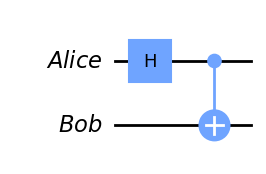

In [3]:
epr_qc = create_epr_state(qreg_alice, qreg_bob)
epr_qc.draw("mpl", style="clifford")

## Adding polarizors with arbitrary angle

We now need a way to measure these qubits in an arbitrary basis. For this, we just need to perform $R_{y}(\theta)$ before measurement, where $\theta$ can be chosen independently by Alice and Bob. Let $\alpha$ and $\beta$ be the angle of the basis chosen by Alice and Bob respectively.

In [4]:
alpha = Parameter('α')
beta = Parameter('β')

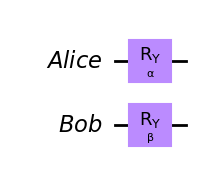

In [7]:
def add_polarizors(qreg_alice, qreg_bob, alpha, beta):
    measurement_qc = QuantumCircuit(qreg_alice, qreg_bob)
    measurement_qc.ry(alpha, qreg_alice)
    measurement_qc.ry(beta, qreg_bob)
    measurement_qc.draw("mpl", style="clifford")
    return measurement_qc

add_pol_qc = add_polarizors(qreg_alice, qreg_bob, alpha, beta)
add_pol_qc.draw("mpl", style="clifford")

## Join these circuits to get the full parametrized circuit

In [10]:
def bells_inequality_qc(qreg_alice, qreg_bob, alpha, beta):
    qc = QuantumCircuit(qreg_alice, qreg_bob)
    qc = qc.compose(create_epr_state(qreg_alice, qreg_bob))
    qc = qc.compose(add_polarizors(qreg_alice, qreg_bob, alpha, beta))
    return qc

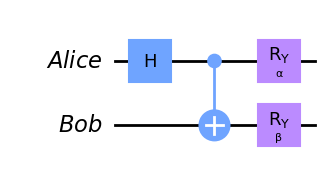

In [11]:
bells_inequality_qc = bells_inequality_qc(qreg_alice, qreg_bob, alpha, beta)
bells_inequality_qc.draw("mpl", style="clifford")

# Create simulator instance

In [12]:
estimator = Estimator()
estimator.set_options(seed=100)

# Confirm $\psi_{\text{EPR}}$ state

In [13]:
observable = SparsePauliOp("Z" * 2)

In [14]:
alpha_beta_pairs = ( (0, 0), (np.pi/2, np.pi/2), (np.pi/4, np.pi/4), (0, np.pi/2) )

In [15]:
N_epr = {}
for alpha_beta in alpha_beta_pairs:
    job = estimator.run(bells_inequality_qc, observable, parameter_values=alpha_beta)
    result = job.result()
    N_epr[alpha_beta] = result.values[0]

$$C = N(0^{\circ}, 90^{\circ})$$
$$A = N(0^{\circ}, 0^{\circ}) + N(90^{\circ}, 90^{\circ}) - 2C $$

In [16]:
C = N_epr[(0, np.pi/2)]
A = N_epr[(0, 0)] +  N_epr[(np.pi/2, np.pi/2)] - 2*C

$$\tan^{2} \theta_{l} = \frac{N(90^{\circ}, 90^{\circ}) - C}{N(0^{\circ}, 0^{\circ}) - C}$$

In [17]:
(N_epr[(np.pi/2, np.pi/2)] - C) / (N_epr[(0, 0)] - C)

1.0

Therefore $\theta_{l} = 45$. The experimental value should be close to this value if you have a pure $\psi_{\text{EPR}}$.

# 16 measurements to calculate S

In [ ]:
alphas = np.arange(-np.pi/4, np.pi/2 + np.pi/4, np.pi/4)
betas = np.arange(-np.pi/8, np.pi/2 + np.pi/4, np.pi/4)

In [ ]:
alphas * 180/np.pi

In [ ]:
betas * 180/np.pi

In [ ]:
N = {}
for alpha in alphas:
    for beta in betas:
        job = estimator.run(full_qc, observable, parameter_values=(alpha, beta))
        result = job.result()
        N[(alpha, beta)] = result.values[0]

In [ ]:
for alpha_beta, exp_val in N.items():
    print(f"{np.array(alpha_beta) * 180/np.pi}: {exp_val}")